In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

BASE_PATH = "/content/drive/MyDrive/Wheat_Disease_Project"

RGB_PATH = os.path.join(BASE_PATH, "Dataset_RGB/Wheat_Leaf_Disease")
HSI_PATH = os.path.join(BASE_PATH, "Dataset_HSI/HyperLeaf2024")

print("RGB classes:", os.listdir(RGB_PATH))
print("HSI files:", os.listdir(HSI_PATH))


RGB classes: ['Brown rust', 'Healthy', 'Loose Smut', 'Septoria', 'Yellow rust']
HSI files: ['sample_submission.csv', 'test.csv', 'train.csv', 'images']


In [ ]:
!pip install --force-reinstall torch torchvision timm spectral scikit-learn captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install torch torchvision timm spectral scikit-learn captum

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

import timm


In [ ]:
import os

IMG_SIZE = 224
BATCH_SIZE = 16

BASE_PATH = "/content/drive/MyDrive/Wheat_Disease_Project"
RGB_PATH = os.path.join(BASE_PATH, "Dataset_RGB/Wheat_Leaf_Disease")

rgb_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

rgb_dataset = datasets.ImageFolder(RGB_PATH, transform=rgb_transforms)

train_size = int(0.8 * len(rgb_dataset))
val_size = len(rgb_dataset) - train_size

rgb_train, rgb_val = torch.utils.data.random_split(
    rgb_dataset, [train_size, val_size]
)

rgb_train_loader = DataLoader(rgb_train, batch_size=BATCH_SIZE, shuffle=True)
rgb_val_loader   = DataLoader(rgb_val, batch_size=BATCH_SIZE, shuffle=False)

NUM_CLASSES = len(rgb_dataset.classes)
print("Disease classes:", rgb_dataset.classes)

Disease classes: ['Brown rust', 'Healthy', 'Loose Smut', 'Septoria', 'Yellow rust']


In [ ]:
# class HyperLeafDataset(Dataset):
#     def __init__(self, root_dir, csv_file):
#         self.root_dir = root_dir
#         self.labels = pd.read_csv(csv_file)

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         row = self.labels.iloc[idx]
#         # Convert ImageId to int first, then to string for the filename
#         img_path = os.path.join(self.root_dir, "images", str(int(row["ImageId"])) + ".npy")

#         cube = np.load(img_path)   # (H, W, Bands)
#         cube = (cube - cube.mean()) / (cube.std() + 1e-6)

#         cube = torch.tensor(cube, dtype=torch.float32).permute(2, 0, 1)

#         target = torch.tensor(row.iloc[1:].values, dtype=torch.float32)
#         return cube, target

In [ ]:
import spectral # Keep existing import for spectral
from PIL import Image # Import Pillow for TIFF loading
import tifffile # Import tifffile for reading multi-band TIFFs

class HyperLeafDataset(Dataset):
    def __init__(self, root_dir, csv_file):
        self.root_dir = root_dir
        self.labels = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        row = self.labels.iloc[idx]
        image_id = int(row["ImageId"]) # Ensure it's an integer
        img_filename = f"{image_id:05d}.tiff"
        img_path = os.path.join(self.root_dir, "images", img_filename)

        try:
            # Use tifffile.imread to open the TIFF file, which handles multi-band images
            # imread returns a numpy array (H, W, Bands)
            cube_np = tifffile.imread(img_path)

            # Ensure the cube_np has 3 dimensions (H, W, C)
            if cube_np.ndim == 2:
                cube_np = np.expand_dims(cube_np, axis=-1)
            elif cube_np.ndim != 3:
                 raise ValueError(f"Expected 2 or 3 dimensions for HSI cube, got {cube_np.ndim}")

            cube = torch.tensor(cube_np, dtype=torch.float32).permute(2, 0, 1) # Convert to C, H, W

        except Exception as e:
            print(f"Error loading {img_path} with tifffile.imread: {e}")
            raise e # Re-raise the exception to indicate failure

        cube = (cube - cube.mean()) / (cube.std() + 1e-6)

        target = torch.tensor(row.iloc[1:].values, dtype=torch.float32)
        return cube, target

In [ ]:
import os

BASE_PATH = "/content/drive/MyDrive/Wheat_Disease_Project"
HSI_PATH = os.path.join(BASE_PATH, "Dataset_HSI/HyperLeaf2024")

hsi_dataset = HyperLeafDataset(
    HSI_PATH,
    os.path.join(HSI_PATH, "train.csv")
)

hsi_loader = DataLoader(hsi_dataset, batch_size=4, shuffle=True)

In [ ]:
class RGBEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
            "efficientnet_b0", pretrained=True, num_classes=0
        )

    def forward(self, x):
        return self.backbone(x)


In [ ]:
class HSLEncoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)


In [ ]:
class FusionNet(nn.Module):
    def __init__(self, num_classes, hsi_channels):
        super().__init__()
        self.rgb = RGBEncoder()
        self.hsi = HSLEncoder(hsi_channels)

        self.classifier = nn.Sequential(
            nn.Linear(1280 + 64, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, rgb, hsi):
        f_rgb = self.rgb(rgb)
        f_hsi = self.hsi(hsi)
        fused = torch.cat([f_rgb, f_hsi], dim=1)
        return self.classifier(fused)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

rgb_model = models.resnet18(pretrained=True)
rgb_model.fc = nn.Linear(rgb_model.fc.in_features, NUM_CLASSES)
rgb_model = rgb_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rgb_model.parameters(), lr=1e-4)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


In [ ]:
for epoch in range(5):
    rgb_model.train()
    for imgs, labels in rgb_train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(rgb_model(imgs), labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} completed")


Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed


In [ ]:
rgb_model.eval()

preds, true = [], []

with torch.no_grad():
    for imgs, labels in rgb_val_loader:
        imgs = imgs.to(device)
        out = rgb_model(imgs)
        preds.extend(out.argmax(1).cpu().numpy())
        true.extend(labels.numpy())

print("Accuracy:", accuracy_score(true, preds))
print(classification_report(true, preds, target_names=rgb_dataset.classes))


Accuracy: 0.9558303886925795
              precision    recall  f1-score   support

  Brown rust       0.99      0.91      0.95       270
     Healthy       0.96      0.97      0.96       323
  Loose Smut       1.00      1.00      1.00       185
    Septoria       0.94      0.83      0.88        76
 Yellow rust       0.90      0.99      0.94       278

    accuracy                           0.96      1132
   macro avg       0.96      0.94      0.95      1132
weighted avg       0.96      0.96      0.96      1132



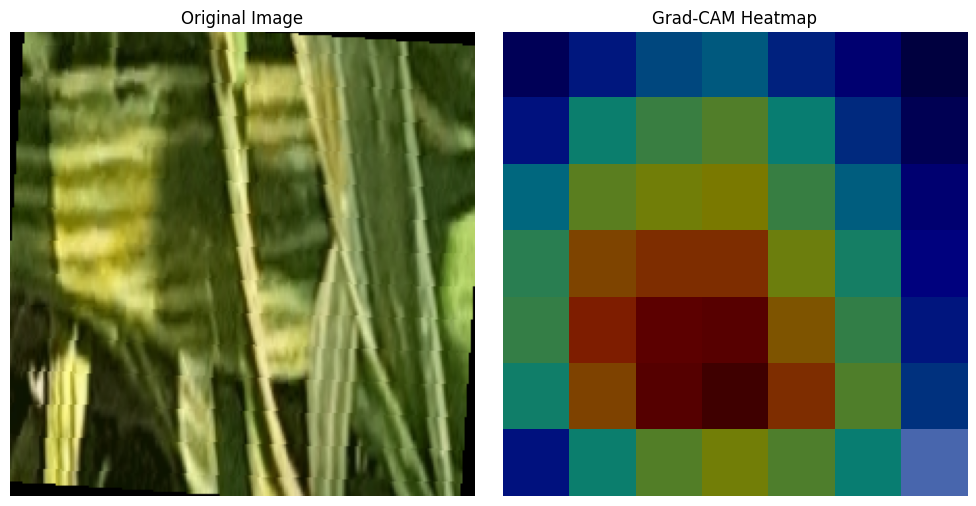

In [ ]:
from captum.attr import LayerGradCam
import matplotlib.pyplot as plt
import numpy as np

# Denormalization helper function
def denormalize_image(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image_np = image.numpy().transpose(1, 2, 0) # Convert from CxHxW to HxWxC
    mean = np.array(mean)
    std = np.array(std)
    image_denorm = image_np * std + mean
    image_denorm = np.clip(image_denorm, 0, 1)
    return image_denorm

layer_gc = LayerGradCam(rgb_model, rgb_model.layer4)

img, label = rgb_val[0]
img_t = img.unsqueeze(0).to(device)

attr = layer_gc.attribute(img_t, target=label)

# Custom visualization using matplotlib
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Original image
denormalized_img = denormalize_image(img.cpu())
ax[0].imshow(denormalized_img)
ax[0].set_title("Original Image")
ax[0].axis("off")

# Grad-CAM heatmap overlay
heatmap = attr.cpu().detach().numpy()[0].mean(axis=0) # Take mean across channels for heatmap
ax[1].imshow(denormalized_img)
ax[1].imshow(heatmap, cmap='jet', alpha=0.5)
ax[1].set_title("Grad-CAM Heatmap")
ax[1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
class FusionDataset(Dataset):
    def __init__(self, rgb_dataset, hsi_dataset):
        self.rgb_dataset = rgb_dataset
        self.hsi_dataset = hsi_dataset

    def __len__(self):
        return min(len(self.rgb_dataset), len(self.hsi_dataset))

    def __getitem__(self, idx):
        rgb_img, rgb_label = self.rgb_dataset[idx]
        hsi_cube, _ = self.hsi_dataset[idx]  # auxiliary task only

        return rgb_img, hsi_cube, rgb_label


In [ ]:
fusion_dataset = FusionDataset(rgb_train, hsi_dataset)
fusion_loader = DataLoader(fusion_dataset, batch_size=4, shuffle=True)


In [ ]:
# infer number of spectral bands automatically
sample_cube, _ = hsi_dataset[0]
HSI_CHANNELS = sample_cube.shape[0]

fusion_model = FusionNet(
    num_classes=NUM_CLASSES,
    hsi_channels=HSI_CHANNELS
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=1e-4)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    fusion_model.train()
    epoch_loss = 0

    for rgb, hsi, label in fusion_loader:
        rgb = rgb.to(device)
        hsi = hsi.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        outputs = fusion_model(rgb, hsi)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {epoch_loss/len(fusion_loader):.4f}")

Epoch [1/10] | Loss: 0.8794
Epoch [2/10] | Loss: 0.4871
Epoch [3/10] | Loss: 0.3341
Epoch [4/10] | Loss: 0.2647
Epoch [5/10] | Loss: 0.1894
Epoch [6/10] | Loss: 0.1535
Epoch [7/10] | Loss: 0.1490
Epoch [8/10] | Loss: 0.1151
Epoch [9/10] | Loss: 0.1231
Epoch [10/10] | Loss: 0.0994


In [ ]:
fusion_model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for rgb, hsi, label in fusion_loader:
        rgb = rgb.to(device)
        hsi = hsi.to(device)

        preds = fusion_model(rgb, hsi).argmax(1)
        y_true.extend(label.numpy())
        y_pred.extend(preds.cpu().numpy())

print("Fusion Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=rgb_dataset.classes))

Fusion Accuracy: 0.989937106918239
              precision    recall  f1-score   support

  Brown rust       1.00      0.97      0.99       357
     Healthy       1.00      1.00      1.00       464
  Loose Smut       1.00      1.00      1.00       265
    Septoria       0.88      0.99      0.93        93
 Yellow rust       1.00      0.99      0.99       411

    accuracy                           0.99      1590
   macro avg       0.97      0.99      0.98      1590
weighted avg       0.99      0.99      0.99      1590



(-0.5, 6.5, 6.5, -0.5)

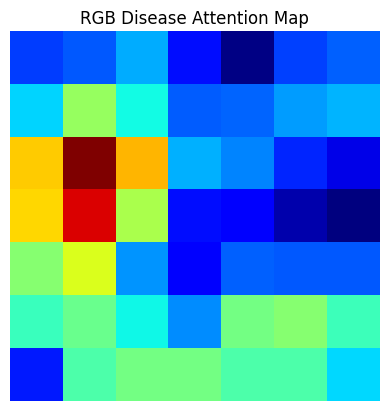

In [ ]:
from captum.attr import LayerGradCam

fusion_model.eval()
gradcam = LayerGradCam(fusion_model.rgb.backbone,
                       fusion_model.rgb.backbone.conv_head)

rgb_img, hsi_cube, label = fusion_dataset[0]
rgb_img = rgb_img.unsqueeze(0).to(device)

attr = gradcam.attribute(rgb_img, target=label)

plt.imshow(attr[0].mean(0).cpu().detach(), cmap='jet')
plt.title("RGB Disease Attention Map")
plt.axis("off")

/tmp/ipython-input-147328731.py:28: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  out[0, label].backward()


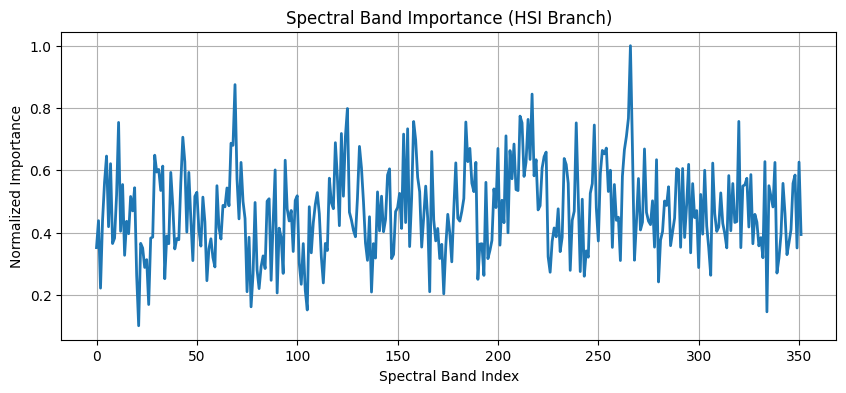

In [ ]:
# ---------------- CELL 16 (FIXED): Spectral Importance (HSI Explainability) ----------------

fusion_model.eval()

# Take ONE sample
rgb_img, hsi_cube, label = fusion_dataset[0]

rgb_img = rgb_img.unsqueeze(0).to(device)
hsi_cube = hsi_cube.unsqueeze(0).to(device)

# ---- Hook to capture gradients BEFORE pooling ----
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Register hooks on the Conv layer of HSI encoder
hsi_conv = fusion_model.hsi.encoder[0]  # Conv2d layer
hsi_conv.register_forward_hook(forward_hook)
hsi_conv.register_full_backward_hook(backward_hook)

# Forward + backward
out = fusion_model(rgb_img, hsi_cube)
out[0, label].backward()

# ---- Spectral importance computation ----
# gradients[0]: (1, 64, H, W)
# activations[0]: (1, 64, H, W)

grad = gradients[0].abs().mean(dim=(2,3))      # (1, 64)
act  = activations[0].mean(dim=(2,3))          # (1, 64)

# Channel importance
channel_importance = (grad * act).squeeze().detach().cpu().numpy()

# Map channel importance back to spectral bands
# Using Conv2d weights: (64, Bands, 3, 3)
conv_weights = hsi_conv.weight.detach().cpu().numpy()
spectral_importance = np.zeros(conv_weights.shape[1])

for c in range(conv_weights.shape[1]):
    spectral_importance[c] = np.sum(
        channel_importance * np.abs(conv_weights[:, c].mean(axis=(1,2)))
    )

# Normalize
spectral_importance /= spectral_importance.max()

# Plot
plt.figure(figsize=(10,4))
plt.plot(spectral_importance, linewidth=2)
plt.title("Spectral Band Importance (HSI Branch)")
plt.xlabel("Spectral Band Index")
plt.ylabel("Normalized Importance")
plt.grid(True)
plt.show()


# fusion_model.eval()

# hsi_cube = hsi_cube.unsqueeze(0).to(device)
# hsi_cube.requires_grad = True

# out = fusion_model(rgb_img, hsi_cube)
# out[0, label].backward()

# spectral_importance = hsi_cube.grad.abs().mean(dim=[0,2,3]).cpu().numpy()

# plt.plot(spectral_importance)
# plt.title("Spectral Band Importance")
# plt.xlabel("Band Index")
# plt.ylabel("Gradient Magnitude")
# plt.show()